# Fluid substitution using Gassmann
Necessary imports

In [1]:
import matplotlib.pyplot as plt
import utils.io as uio
from core.well import Project, Well
from core.minerals import MineralSet
from core.fluids import FluidSet
import rp.rp_core as rp

## Create a project
The project remembers where important information is stored, and controls the logging

In [2]:
wp = Project(
    name='FluidSub', 
    project_table='excels/project_table.xlsx',
    tops_file='test_data/RokDocTops.xlsx', 
    tops_type='rokdoc')

Note that relative path names are allowed
*Project* also take keywords:
- *working_dir* - the folder where the project is situated
- *log_to_stdout* - if True, logging information is sent to standard output, else to a text file

By default, none of these need to set, and it uses the install directory, toghether with example data and project table there

## Load project table
The project table is a .xlsx file that contain, which wells and well logs to load, where to find them, and important for fluid substitution; the fluids and minerals.

### Wells
The *Wells table* sheet of the *project_table.xlsx* holds information about which wells and well logs to use.
<img src="images/Fluid substitution - wells.png" />
In this case, we only read in Well F, and the selected well logs that the las file *test_data/Well F.las* contains.

Load the well table through

In [3]:
well_table = uio.project_wells(wp.project_table, wp.working_dir)

In [4]:
for key in list(well_table):
    print('{}: {}'.format(well_table[key]['Given well name'], key))

WELL_F: test_data/Well F.las


### Fluids
The *Fluids* sheet of the *project_table.xlsx* holds information about the fluids that our fluid mixtures contains.
<img src="images/Fluid substitution - fluids.png" />
The first column determines if the fluid belongs to the *Initial* or *Final* fluids.

Column *B* to *E* contains name, bulk and shear modolus, and density (if column *F* is set to *User specified*). The option to use Batzle and Wang method to calculate the elastic fluid properties is still not fully implemented, so the *Default* fluid in this example is ignored by the system right now.

Column *P* determines which Volume fraction (saturation) to use for the fluid. Set it to the name of a well log (*SW* for the final Brine saturation in this example), or *complement* if the fluids takes up the remaining volume, or a number if a constant saturation is requested.

Load the fluids through

In [5]:
myfluids = FluidSet() 
myfluids.read_excel(wp.project_table)
print(myfluids)

initial fluids:
  brine
    K: 2.8, Mu: nan, Rho 1.1
    Calc. method: User specified
    Volume fraction: 1.0
final fluids:
  oil
    K: 0.9, Mu: nan, Rho 0.8
    Calc. method: User specified
    Volume fraction: complement
  brine
    K: 2.8, Mu: nan, Rho 1.1
    Calc. method: User specified
    Volume fraction: sw



### Minerals
The *Minerals* sheet of the *project_table.xlsx* holds information about the minerals used in the calculation of the mineral bulk modulus
<img src="images/Fluid substitution - minerals.png" />
Column *A* to *D* contains name, bulk and shear modolus, and density of minerals. 

Column *F* determines which Volume fraction (saturation) to use for the minerals. Set it to the name of a well log (*VCL* for the Shale in this example), or *complement* if the mineral takes up the remaining volume, or a number if a constant volume fraction is requested. 

Minerals for which no *Volume fraction* is specified are ignored by the system.

Load the minerals through

In [6]:
mymins = MineralSet() 
mymins.read_excel(wp.project_table)
print(mymins)

Quartz
  K: 36.6, Mu: 45.0, Rho 2.65
  Volume fraction: complement
Shale
  K: 11.4, Mu: 3.0, Rho 2.35
  Volume fraction: vcl



## Fluid substitution
First the selected well (Well F) is loaded, which has index 0 in the loaded *well_table*

**Note** Well_F in case, uses VSH as name for shale volume, while the others wells, and most importantly, the Shale *volume fraction*, use VCL. To rename from VSH to VCL upon loading the log, use the following

In [11]:
w = Well() 
w.read_well_table(well_table, 0, block_name='FBlock', rename_well_logs={'VCL': ['VSH']})

The *block_name* key word is used to name the logs of *Well F* under well *w*

Then the cut-offs, used to define a sand which the fluid substitution will be constrained to, is set 

In [12]:
cutoffs = {'Volume': ['<', 0.5], 'Porosity': ['>', 0.1]}
w.calc_mask(cutoffs, name='sand_mask', log_type_input=True)

XXXX
vcl: < 0.5, phie: > 0.1, 


Then the mask can be loaded as a boolean array

In [13]:
mask = w.block['FBlock'].masks['sand_mask'].data

### Mineral bulk modulus and porosity
Calculate the mineral bulk modulus using the Voigt-Reuss-Hill average of the volume fractions of the minerals defined in *mymins*. And extract the porosity

In [14]:
k0 = w.calc_vrh_bounds(mymins, param='k', method='Voigt-Reuss-Hill', block='FBlock')
por = w.block['FBlock'].logs['phie'].data

 Mineral: Quartz, volume frac: complement
 Mineral: Shale, volume frac: vcl


C:\Users\mblixt\PycharmProjects\blixt_rp\rp\rp_core.py:469: RuntimeWarning: invalid value encountered in greater
  if (abs(sum(f) - 1.0) > 0.02).any():


### Initial values
Calculate the density and bulk modulus of the initial fluids

In [15]:
rho_f1 = w.calc_vrh_bounds(myfluids.fluids['initial'], param='rho', method='Voigt', block='FBlock')
k_f1 = w.calc_vrh_bounds(myfluids.fluids['initial'], param='k', method='Reuss', block='FBlock')

 Mineral: brine, volume frac: 1.0
 Mineral: brine, volume frac: 1.0


And extract the initial vp, vs and rho of the saturated rocks from the logs

In [16]:
v_p_1 = w.block['FBlock'].logs['vp_dry'].data
v_s_1 = w.block['FBlock'].logs['vs_dry'].data
rho_1 = w.block['FBlock'].logs['rho_dry'].data

### Final values
The density and bulk modulus of the final fluids 

In [17]:
rho_f2 = w.calc_vrh_bounds(myfluids.fluids['final'], param='rho', method='Voigt', block='FBlock')
k_f2 = w.calc_vrh_bounds(myfluids.fluids['final'], param='k', method='Reuss', block='FBlock')

 Mineral: oil, volume frac: complement
 Mineral: brine, volume frac: sw
 Mineral: oil, volume frac: complement
 Mineral: brine, volume frac: sw


Then the final elastic properties can be calculated using Gassmann's

In [18]:
v_p_2, v_s_2, rho_2, k_2 = rp.gassmann_vel(v_p_1, v_s_1, rho_1, k_f1, rho_f1, k_f2, rho_f2, k0, por)


C:\Users\mblixt\PycharmProjects\blixt_rp\rp\rp_core.py:573: RuntimeWarning: invalid value encountered in less
  por[por < 7E-3] = 7E-3
C:\Users\mblixt\PycharmProjects\blixt_rp\rp\rp_core.py:596: RuntimeWarning: invalid value encountered in sqrt
  v_p_2 = np.sqrt((k_2+(4/3)*mu_2) / rho_2) * 1E3  # m/s


### Store results in well object

In [19]:
w.block['FBlock'].add_log(
    v_p_2, 
    'vp_oil', 
    'P velocity', 
    header={'unit': 'm/s', 'desc': 'Oil saturated Vp', 'modification_history': 'Fluid substituted Vp'})
w.block['FBlock'].add_log(
    v_s_2, 
    'vs_oil', 
    'S velocity', 
    header={'unit': 'm/s', 'desc': 'Oil saturated Vs', 'modification_history': 'Fluid substituted Vs'})
w.block['FBlock'].add_log(
    rho_2, 
    'rho_oil', 
    'Density', 
    header={'unit': 'g/cm3', 'desc': 'Oil saturated density', 'modification_history': 'Fluid substituted density'})

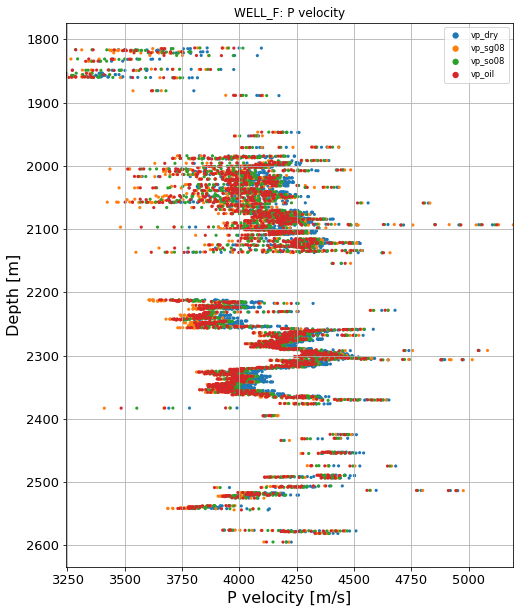

In [20]:
w.depth_plot('P velocity', mask=mask)

Save the well as a las file

In [37]:
uio.write_las('results_folder/test.las', w.header, w.block['FBlock'].header, w.block['FBlock'].logs)